# Data Pre-Processing and Analytics (Part 2)
This notebook demonstrates methods of data pre-processing and analytics.

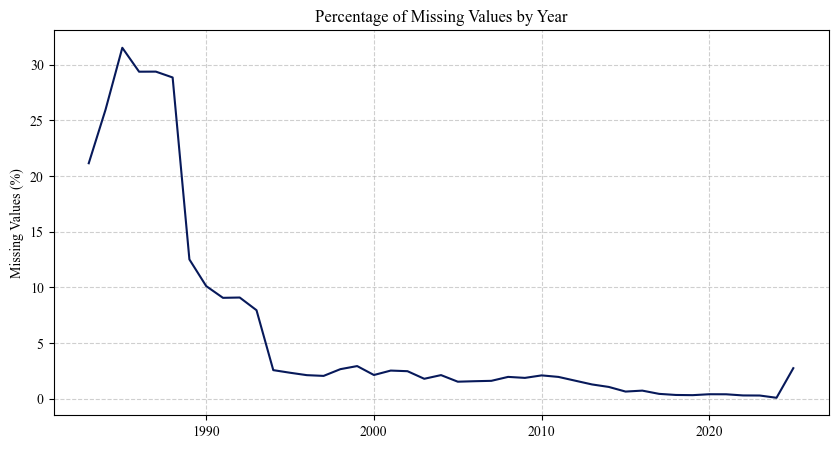

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json

files = [
    "income_statement",
    "balance_sheet",
    "cashflow_statement",
    "financial_metrics",
    "financial_ratios",
    "income_statement_growth",
    "balance_sheet_growth",
    "cashflow_statement_growth",
    "dividend_adjusted_prices",
    "index_data",
    "index_1yr_returns"
]

dataset = {name: pd.read_csv(f"data/{name}.csv") for name in files}
for name, df in dataset.items():
    globals()[f"df_{name}"] = df
    if "reportedCurrency" in df.columns:
        dataset[name] = df[df["reportedCurrency"] == "USD"]

def sel_rename(df, mapping):
    return df.rename(columns=mapping)[list(mapping.values())]
    
with open('renamers.json', 'r') as f:
    renamers = json.load(f)
    
dataset_renamed = {}
for name, df in dataset.items():
    mapper = renamers.get(name)
    if mapper is None:
        continue
    renamed_df = sel_rename(df, mapper)
    if 'year' in renamed_df.columns:
        renamed_df['year'] = renamed_df['year'].astype(str)
    dataset_renamed[name] = renamed_df

df_stock_returns = (
    df_dividend_adjusted_prices
      .assign(date=lambda d: pd.to_datetime(d["date"]))
      .rename(columns={"symbol": "ticker"})
      .assign(year=lambda d: d["date"].dt.year.astype(str))
      .sort_values(["ticker","date"])
      .groupby(["ticker","year"], as_index=False)
      .agg(first=("adjClose","first"), last=("adjClose","last"))
      .assign(pct_return=lambda x: (x["last"]/x["first"] - 1)*100)
      [["ticker","year","pct_return"]]
)
df_stock_returns.to_csv("data/stock_returns.csv", index=False)

df_merged = df_stock_returns.copy()
for key in renamers:
    if key in dataset_renamed:
        df_merged = df_merged.merge(dataset_renamed[key], on=["ticker","year"], how="outer")
df_merged["year"] = pd.to_numeric(df_merged["year"]).astype("Int64")

for col in [c for c in df_merged.columns if c.endswith("_growth")]:
    df_merged[col] = df_merged[col] * 100

n_cols = df_merged.shape[1] - 2
df_merged["missing_pct_row"] = ((df_merged.drop(columns=["ticker","year"]).isna().sum(axis=1) / n_cols) * 100.0)
missing_pct_year = (df_merged.groupby("year")["missing_pct_row"].mean().reset_index(name="avg_missing_pct"))

mpl.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(10,5))
plt.plot(missing_pct_year["year"], missing_pct_year["avg_missing_pct"], color="#07195a")
plt.title("Percentage of Missing Values by Year")
plt.xlabel("")
plt.ylabel("Missing Values (%)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [2]:
df_merged = df_merged.sort_values(["ticker","year"])
for g in [c for c in df_merged.columns if c.endswith("_growth")]:
    base = g[:-7]
    prev = df_merged.groupby("ticker")[base].shift(1)
    calc = ((df_merged[base] / prev) - 1) * 100.0
    mask = df_merged[g].isna() & prev.notna() & (prev != 0) & df_merged[base].notna()
    df_merged.loc[mask, g] = calc[mask]
mask = df_merged["book_value_per_share"].isna() & df_merged["stockholders_equity"].notna() & df_merged["shares_outstanding"].notna()
df_merged.loc[mask, "book_value_per_share"] = (df_merged.loc[mask, "stockholders_equity"] / df_merged.loc[mask, "shares_outstanding"])

df_merged = df_merged[df_merged["year"] >= 1995]
missing_pct_by_col = (df_merged.isna().mean().sort_values(ascending=False) * 100)
missing_pct_by_col.head()

pct_return                          17.246765
depreciation_amortization            1.234568
depreciation_amortization_growth     1.234568
net_change_cash                      1.234568
operating_cashflow                   1.234568
dtype: float64

In [3]:
missing_pct_return_by_year = (df_merged.groupby("year")["pct_return"].apply(lambda x: x.isna().mean() * 100).reset_index(name="missing_pct"))
missing_pct_return_by_year.head(10)

,year,missing_pct
0,1995,100.000000
1,1996,100.000000
2,1997,100.000000
3,1998,100.000000
4,1999,100.000000
5,2000,10.224439
6,2001,9.903382
7,2002,10.000000
8,2003,10.141509
9,2004,8.196721


In [4]:
df_merged = df_merged[(df_merged["year"] >= 2000) & (df_merged["year"] <= 2024)]
df_merged = df_merged[df_merged["missing_pct_row"] <= 5]
missing_pct_by_col = (df_merged.isna().mean().sort_values(ascending=False) * 100)
missing_pct_by_col.head()

pct_return                   3.62078
ticker                       0.00000
net_change_cash              0.00000
ppe_growth                   0.00000
non_current_assets_growth    0.00000
dtype: float64

In [5]:
df_merged = df_merged.dropna(subset=["pct_return"])
df_merged.isna().any().any()

np.False_

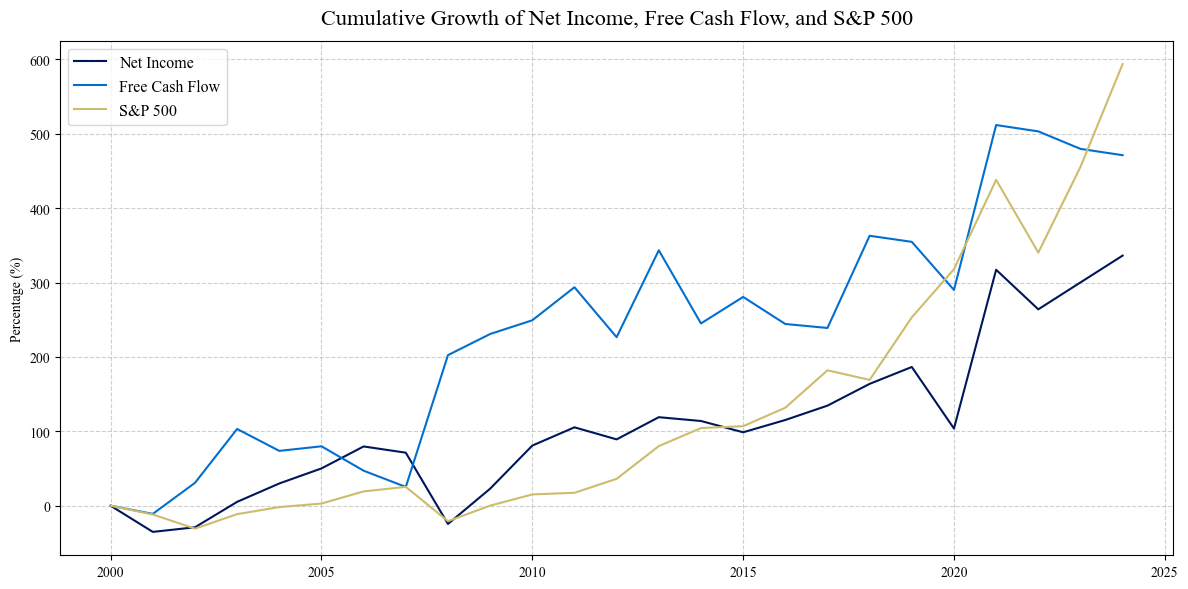

In [6]:
df_merged.to_csv("data/merged_financial_data.csv", index=False)

agg = (df_merged[df_merged["year"] >= 2000].groupby("year")[["net_income", "free_cashflow"]].mean().sort_index())
def cum_pct(s, base_year=2000):
    return (s / s.loc[base_year] - 1) * 100
cum_df = agg[["net_income", "free_cashflow"]].apply(cum_pct)
index_cum = (df_index_data[df_index_data["year"] >= 2000].sort_values("date").groupby("year")["adjClose"].last().pipe(lambda s: (s / s.loc[2000] - 1) * 100))
cum_df = cum_df.join(index_cum.rename("S&P 500 Total Return"), how="inner")
plot_df = cum_df.reset_index()

plt.figure(figsize=(12,6))
plt.plot(plot_df["year"], plot_df["net_income"], label="Net Income", color="#00165b")
plt.plot(plot_df["year"], plot_df["free_cashflow"], label="Free Cash Flow", color="#026fd0")
plt.plot(plot_df["year"], plot_df["S&P 500 Total Return"], label="S&P 500", color="#cdbc6c")
plt.title("Cumulative Growth of Net Income, Free Cash Flow, and S&P 500", fontsize=16, pad=12)
plt.xlabel("")
plt.ylabel("Percentage (%)")
plt.legend(fontsize=11.5)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

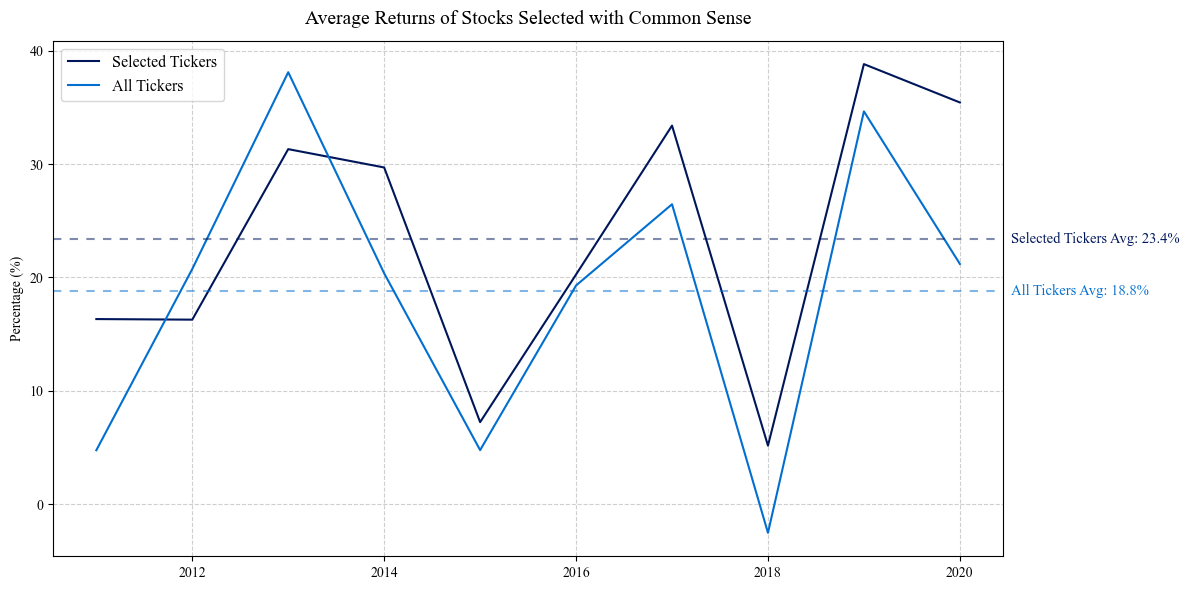

In [7]:
df_returns = df_merged[["ticker", "year", "pct_return"]]
checklist = (
    df_merged.query("2001 <= year <= 2010")
    .groupby("ticker")[["cash_and_equivalents","long_term_debt","net_income_growth","free_cashflow_growth","revenue_growth","pe"]]
    .mean()
)
common_sense_checklist = checklist[
    (checklist["cash_and_equivalents"] > checklist["long_term_debt"]) &
    (checklist["net_income_growth"] > 15) &
    (checklist["free_cashflow_growth"] > 15) &
    (checklist["revenue_growth"] > 15) &
    (checklist["pe"] < 50)
].index

df_mean_all = df_returns.query("2011 <= year <= 2020").groupby("year")["pct_return"].mean()
df_common_sense = df_returns.query("2011 <= year <= 2020 and ticker in @common_sense_checklist").groupby("year")["pct_return"].mean()
avg_common_sense = df_common_sense.mean()
avg_all = df_mean_all.mean()

plt.figure(figsize=(12, 6))
plt.plot(df_common_sense.index, df_common_sense.values, label="Selected Tickers", color="#00165b")
plt.plot(df_mean_all.index, df_mean_all.values, label="All Tickers", color="#026fd0")
plt.xlabel("")
plt.ylabel("Percentage (%)")
plt.title("Average Returns of Stocks Selected with Common Sense", fontsize=14, pad=12)
plt.legend(fontsize=11.5)
plt.grid(True, linestyle="--", alpha=0.6)
ax = plt.gca()
ax.axhline(avg_common_sense, linestyle=(0, (4, 4)), color="#00165b", alpha=0.5)
ax.axhline(avg_all, linestyle=(0, (4, 4)), color="#026fd0", alpha=0.5)
xmax = ax.get_xlim()[1]
for y, color, label in [(avg_common_sense, "#00165b", "Selected Tickers Avg"), (avg_all, "#026fd0", "All Tickers Avg")]:
    ax.annotate(
        f"{label}: {y:.1f}%",
        xy=(xmax, y), xycoords=("data", "data"),
        xytext=(6, 0), textcoords="offset points",
        ha="left", va="center", fontsize=10.5, color=color)
plt.tight_layout()
plt.show()

> Stocks were selected with a common-sense checklist: (1) cash and cash equivalents exceed long term debt; (2) net income, free cash flow, and revenue are each growing at 15+%; and (3) PE is below 50. The criteria were applied to the average metrics of each ticker from 2001-2010. Returns were then plotted for 2011-2020.<br>
> ***A simple common-sense checklist can greatly increase your odds of success if applied.***